In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.2'

This workbook is a modified version of the workbook created for chapter 6 section of Deep Learning with Python, a highly recommended book and sample code source. The book is available at: https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff 

This is also using convnets over text sequences - meant to be more standalone that the book version, any mistakes are mine.

In Keras, you would use a 1D convnet via the Conv1D layer, which has a very similar interface to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.
Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.
As a reminder, this is the code for obtaining and preprocessing the data:

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000       # number of words to consider as features
max_len      = 500         # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts that you have used in Chapter 5: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.
One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.
This is our example 1D convnet for the IMDB dataset:
(note - experimenting with the window/kernal/filter size is always interesting)

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Dropout

#original settings get us 74% accuracy
#change to 8 epochs and defaults results in .8174 val_acc - highest so far - prevent overfitting 
model = Sequential()

model.add(layers.Embedding(max_features, 128, input_length=max_len)) #orig 128 
model.add(layers.Conv1D(32, 7, activation='relu'))  #orig 32,7,activation=relu; kernel to 9-> .7456
model.add(layers.MaxPooling1D(5))                   #orig 5 with 9 get a val_acc of .7682, with 5 val_acc=.7468
model.add(Dropout(0.2))                             #jw test 8/14
model.add(layers.Conv1D(32, 7, activation='relu'))  #orig 32,7,relu; kernel to 9-> .7356
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=8,                #orig 10 - try 8
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total para

At that point, we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task. - let's validate that claim by changing epochs but let's also add plotting

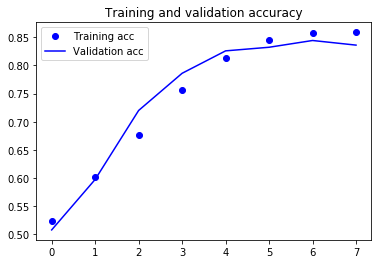

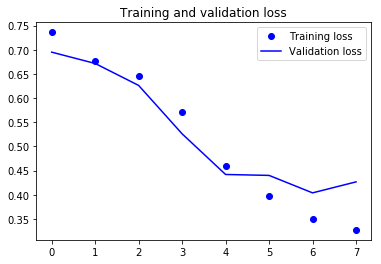

In [4]:
%matplotlib inline 
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [8]:
#there is an issue here - the original tokenizer must be saved and used again. a new instance of the tokenizer will not work so
#this is a placeholder until i take care of that. this will run but provides nonsense results in current form 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

text = ['that movie was bad was bad was bad my oh my']

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(text)
print(tokenizer)
sequences=tokenizer.texts_to_sequences(text)

print(sequences)
word_index=tokenizer.word_index

ptext = pad_sequences(sequences,maxlen=max_len) #pad my input to 500 as defined eariler
print('ptext shape: ',ptext.shape)

prediction = model.predict(np.array(ptext))
print(prediction[0][0])

[[4, 5, 1, 2, 1, 2, 1, 2, 3, 6, 3]]
ptext shape:  (1, 500)
0.34132499
